# Capstone Project - Battle of the Neighborhoods
## New York vs Toronto

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import geocoder 
import folium
import json
from geopy.geocoders import Nominatim
import requests
import math
import seaborn as sns

from sklearn.cluster import KMeans 
from sklearn import preprocessing

import urllib.request

%matplotlib inline 

## Get Toronto Data

In [2]:
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get(url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
content = driver.page_source
soup = BeautifulSoup(content)
driver.close()

Trying to download new driver from http://chromedriver.storage.googleapis.com/80.0.3987.106/chromedriver_win32.zip
Unpack archive C:\Users\Amritha PC\.wdm\drivers\chromedriver\80.0.3987.106\win32\chromedriver.zip


In [3]:
# get contents of webpage
table = soup.find('table')

# extract table headers
table_cols = table.find_all('th')
labels=[i.text.strip('\n') for i in table_cols]
#print(labels)

table_rows = table.find_all('tr')
data = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text.strip('\n') for i in td]
    if len(row)>0:
        #print(row)
        data.append(row)

In [4]:
# write into a df
df = pd.DataFrame(columns=labels, data=np.array(data).reshape(len(data),-1))
df = df[df['Borough'] != 'Not assigned']
df = df.reset_index(drop=True)
#df = df[df['Neighborhood'] != '']
df.head()

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


**Get the coordinates of all the neighborhoods and add it to the dataframe**

In [5]:
coord = pd.read_csv("Geospatial_coordinates.csv")
p_code = df['Postal code'].tolist()

lat = []
long = []
for p in p_code:
    lat.append(coord[coord['Postal Code']==p]['Latitude'].values[0])
    long.append(coord[coord['Postal Code']==p]['Longitude'].values[0])
    
df['Latitude'] = lat 
df['Longitude'] = long 
df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494


### Explore the data by plotting

In [6]:
g = geocoder.osm('Toronto, Ontario')
latitude_toronto = g.latlng[0]
longitude_toronto = g.latlng[1]

# create map of Manhattan using latitude and longitude values
toronto_map = folium.Map(location=[latitude_toronto+0.05, longitude_toronto], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

## Get New York Data

In [7]:
url = 'https://cocl.us/new_york_dataset'
filename = 'newyork_data.json'
urllib.request.urlretrieve(url, filename)

('newyork_data.json', <http.client.HTTPMessage at 0x1e7afe9adc8>)

Load the NY data

In [8]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0])
)
neighborhoods.head()

The dataframe has 5 boroughs and 306 neighborhoods.


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


**Explore the data by plotting**

In [9]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_ny = location.latitude
longitude_ny = location.longitude

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## Using Foursquare API to explore the neighborhoods
Note that foursquare client_id, client_secret_id are removed before posting on Github.

In [10]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20201004' # Foursquare API version

explore_ny_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET,  VERSION, latitude_toronto, longitude_toronto, 500, 100)
explore_toronto_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET,  VERSION, latitude_ny, longitude_ny, 500, 100)

In [11]:
# functions taken from Courser Capstone Project from IBM Data Science Certification
# Added a check for key error - not all neighborhood's have group key

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# function to get nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        try:
            venues = results['response']['groups'][0]['items']
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in venues])
        except KeyError:
            print(f"{name}'s group is unknown.")
        #venues = results['response']['groups'][0]['items']
               
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
ny_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

In [ ]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [14]:
ny_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [15]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


## Look at venue categories per neighborhood

In [16]:
ny_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,30,30,30,30,30,30
Annadale,8,8,8,8,8,8
Arden Heights,4,4,4,4,4,4
Arlington,7,7,7,7,7,7
Arrochar,21,21,21,21,21,21
Arverne,18,18,18,18,18,18
Astoria,100,100,100,100,100,100
Astoria Heights,14,14,14,14,14,14
Auburndale,18,18,18,18,18,18


In [39]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
Alderwood / Long Branch,8,8,8,8,8,8
Bathurst Manor / Wilson Heights / Downsview North,20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
Bedford Park / Lawrence Manor East,25,25,25,25,25,25
Berczy Park,55,55,55,55,55,55
Birch Cliff / Cliffside West,4,4,4,4,4,4
Brockton / Parkdale Village / Exhibition Place,23,23,23,23,23,23
Business reply mail Processing CentrE,16,16,16,16,16,16


In [13]:
# Back up pulled data to conserve queries.

#backup = pd.HDFStore('backup.h5')
#backup['ny_venues'] = ny_venues
#backup['toronto_venues'] = toronto_venues
#backup.close()

#backup = pd.HDFStore('backup.h5')
#toronto_venues = backup['toronto_venues']
#ny_venues = backup['ny_venues']
#backup.close()

## Select busy neighborhoods based on number of venues in that neighborhood

In [16]:
# select "busy" neighborhoods - we define "busy" as neighborhoods with at least 80 PoIs nearby
ny_nbrs = ny_venues.groupby('Neighborhood').count().reset_index()
ny_list = ny_nbrs.loc[ny_nbrs['Venue'] > 80]['Neighborhood'].tolist()
df_ny = neighborhoods.loc[neighborhoods['Neighborhood'].isin(ny_list)].reset_index()
df_ny

,index,Borough,Neighborhood,Latitude,Longitude
0,16,Bronx,Fordham,40.860997,-73.896427
1,34,Bronx,Belmont,40.857277,-73.888452
2,46,Brooklyn,Bay Ridge,40.625801,-74.030621
3,49,Brooklyn,Greenpoint,40.730201,-73.954241
4,59,Brooklyn,Prospect Heights,40.676822,-73.964859
5,64,Brooklyn,Brooklyn Heights,40.695864,-73.993782
6,65,Brooklyn,Cobble Hill,40.687920,-73.998561
7,66,Brooklyn,Carroll Gardens,40.680540,-73.994654
8,84,Brooklyn,Clinton Hill,40.693229,-73.967843
9,86,Brooklyn,Downtown,40.690844,-73.983463


In [17]:
# create map of New York using latitude and longitude values
map_ny = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_ny['Latitude'], df_ny['Longitude'], df_ny['Borough'], df_ny['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  
    
map_ny

In [18]:
# select "busy" neighborhoods - we define "busy" as neighborhoods with at least 80 PoIs nearby
t_nbrs = toronto_venues.groupby('Neighborhood').count().reset_index()
t_list = t_nbrs.loc[t_nbrs['Venue'] > 80]['Neighborhood'].tolist()
df_tor = df.loc[df['Neighborhood'].isin(t_list)].reset_index()
df_tor

,index,Postal code,Borough,Neighborhood,Latitude,Longitude
0,9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
1,15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
2,30,M5H,Downtown Toronto,Richmond / Adelaide / King,43.650571,-79.384568
3,36,M5J,Downtown Toronto,Harbourfront East / Union Station / Toronto Is...,43.640816,-79.381752
4,42,M5K,Downtown Toronto,Toronto Dominion Centre / Design Exchange,43.647177,-79.381576
5,48,M5L,Downtown Toronto,Commerce Court / Victoria Hotel,43.648198,-79.379817
6,92,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846
7,97,M5X,Downtown Toronto,First Canadian Place / Underground city,43.648429,-79.382280


In [116]:
# create map of New York using latitude and longitude values
map_tor = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_tor['Latitude'], df_tor['Longitude'], df_tor['Borough'], df_tor['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
    
map_tor

#### Observation 1: 

**New York has more "busy" places compared to Toronto. Furthermore, these areas are spread over 4 of the 5 boroughs in NY, while it is localized to one borough in Toronto.**

## Analyze the neighborhoods

In [20]:
# one hot encoding - NY
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Ot

In [21]:
# one hot encoding - toronto
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Understanding the different kinds of venues in each city

In [22]:
ny1 = ny_onehot.apply(pd.to_numeric, errors='coerce').sum()
ny1 = ny1.rename_axis('venue').reset_index()
ny1 = ny1.rename(columns={0: "freq"})
ny1
#df = pd.DataFrame({'venue': speed,'freq': lifespan}, index=index)

,venue,freq
0,Yoga Studio,77.0
1,ATM,1.0
2,Accessories Store,7.0
3,Adult Boutique,1.0
4,Afghan Restaurant,3.0
5,African Restaurant,4.0
6,Airport Terminal,1.0
7,American Restaurant,165.0
8,Antique Shop,11.0
9,Arcade,3.0


In [23]:
t1 = toronto_onehot.apply(pd.to_numeric, errors='coerce').sum()
t1 = t1.rename_axis('venue').reset_index()
t1 = t1.rename(columns={0: "freq"})
t1

,venue,freq
0,Yoga Studio,13.0
1,Accessories Store,1.0
2,Airport,2.0
3,Airport Food Court,1.0
4,Airport Gate,1.0
5,Airport Lounge,2.0
6,Airport Service,2.0
7,Airport Terminal,2.0
8,American Restaurant,29.0
9,Antique Shop,3.0


#### Observation 2: NY has more venues offering the same facilities/experience compared to Toronto. 
Ex: NY has 77 yoga studios as opposed to 13 in Toronto. Similar trend in a lot of facilities


#### Observation 3: NY offers more multi cultural experiecnces than Toronto. 
Examples of mulitculatural venues in NY not in Toronto: Argentinian Restaurant, Australian Restaurant, Austrian Restaurant, Arepa restraunt, etc.  

**Based on the above three observation, it is advantageous to open a multicultural restaurant in Downtown Toronto. 
There seems to be lack of such restaurants in Toronto. For example, Downtown Toronto lacks a Kebab restaurant. In addition, the Downtown is a very popular place with many neighborhoods with more than 80 venues. This makes it an ideal place to start a business as the neighborhood is frequently visited by people in general**

The next step is to identify a specific location within Downtown Toronto to start the restaurant. We will use k-means clustering to find one big cluster and thus its centroid. The key idea would be cluster all the busy neighborhoods and locate the restaurant close to the centre of the largest cluster. This is based on the assumption that we want the restaurant to be located at the center of the most popular neighborhood.

## K-Means Clustering

In [24]:
X_toronto = df_tor[['Latitude','Longitude']]
y_toronto = df_tor['Neighborhood']

#### Find centroid location

In [25]:
kM_toronto = KMeans(n_clusters=1, random_state=0)
y_pred_toronto = kM_toronto.fit_predict(X_toronto)
centroid = kM_toronto.cluster_centers_
print(centroid[0])

[ 43.64878529 -79.37989929]


**Thus, this would be a good location to open a Kebab restaurant in Toronto.**

### Visualize on map

In [113]:
# create map
map_t = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=14)

label = folium.Popup( 'Restaurant Location', parse_html=True)
folium.CircleMarker(
            centroid[0],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7).add_to(map_t)
       
map_t

#### We narrowed down a location based on the FourSquare data. In practice, it is often advantageous to corroborate the findings by comparing results against another dataset. 

We will now use the BikeShare data from the Open Data provided by the City of Toronto to verify that the location we narrowed down for starting the business is indeed a popular location. Bikeridership data for 2018 Q4 is selected for this analysis (This is the latest dataset found).

In [29]:
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "7e876c24-177c-4605-9cef-e50dd74c617f"}
response = urllib.request.urlopen(url, data=bytes(json.dumps(params), encoding="utf-8"))
package = json.loads(response.read())
print(package["result"]) # package metadata

{'license_title': 'Open Government Licence – Toronto', 'owner_unit': None, 'relationships_as_object': [], 'topics': 'Transportation', 'owner_email': 'Alyssa.Krantzberg@toronto.ca', 'excerpt': 'Historical Bike Share Toronto Ridership data. ', 'private': False, 'owner_division': 'Toronto Parking Authority', 'num_tags': 9, 'id': '7e876c24-177c-4605-9cef-e50dd74c617f', 'metadata_created': '2019-07-23T16:40:26.101562', 'refresh_rate': 'Annually', 'title': 'Bike Share Toronto Ridership Data', 'license_url': 'https://open.toronto.ca/open-data-license/', 'state': 'active', 'information_url': 'http://www.bikesharetoronto.com', 'license_id': 'open-government-licence-toronto', 'type': 'dataset', 'resources': [{'cache_last_updated': None, 'package_id': '7e876c24-177c-4605-9cef-e50dd74c617f', 'datastore_active': False, 'id': 'f931a332-09de-494b-afb0-c811c6ec4043', 'size': 1465200, 'format': 'XLSX', 'state': 'active', 'hash': '', 'description': '', 'is_preview': False, 'last_modified': '2019-07-23T1

In [30]:
bike = pd.read_csv("Toronto Ridership_Q4_2018.csv")
bike.head()

,trip_id,trip_duration_seconds,from_station_id,trip_start_time,from_station_name,trip_stop_time,to_station_id,to_station_name,user_type
0,4158592,749,7061,10/1/2018 0:01,Dalton Rd / Bloor St W,10/1/2018 0:14,7042,Sherbourne St / Wellesley St E,Annual Member
1,4158593,433,7003,10/1/2018 0:06,Madison Ave / Bloor St W,10/1/2018 0:13,7280,Charles St E / Jarvis St - SMART,Annual Member
2,4158594,285,7024,10/1/2018 0:14,Dundonald St / Church St,10/1/2018 0:19,7028,Gould St / Mutual St,Annual Member
3,4158595,150,7190,10/1/2018 0:16,St. George St / Hoskin Ave,10/1/2018 0:18,7161,Beverley St / College St,Annual Member
4,4158596,744,7265,10/1/2018 0:21,Wallace Ave / Symington Ave - SMART,10/1/2018 0:33,7136,Queen St W / Close Ave,Annual Member


In [90]:
b = bike['from_station_name'].value_counts()
b = b.rename_axis('Street').reset_index()
b = b.rename(columns={'from_station_name':'Count'})
b.head()

,Street,Count
0,Sherbourne St / Wellesley St E,4089
1,Bay St / Wellesley St W,3719
2,Bay St / College St (East Side),3447
3,Union Station,3274
4,Dundas St W / Yonge St,3219


In [53]:
# count how many trips start and end from each station and make a new dataframe
stations = bike.from_station_id.unique()
stations.sort()
stn_loc = []
ss = ', Toronto, CA'
for s in stations:
    loc = bike.loc[bike['from_station_id'] == s, 'from_station_name'].iloc[0]
    stn_loc.append(loc)
    bike['from_station_id'].value_counts()
    print(s,loc)


7000 Fort York  Blvd / Capreol Ct
7001 Lower Jarvis St / The Esplanade
7002 St. George St / Bloor St W
7003 Madison Ave / Bloor St W
7004 University Ave / Elm St
7005 King St W / York St
7006 Bay St / College St (East Side)
7007 College St / Huron St
7008 Wellesley St / Queen's Park Cres
7009 King St E / Jarvis St
7010 King St W / Spadina Ave
7011 Wellington St W / Portland St
7012 Elizabeth St / Edward St (Bus Terminal)
7013 Scott St / The Esplanade
7014 Sherbourne St / Carlton St (Allan Gardens)
7015 King St W / Bay St (West Side)
7016 Bay St / Queens Quay W (Ferry Terminal)
7017 Widmer St / Adelaide St W
7018 Bremner Blvd / Rees St
7019 Temperance St. Station
7020 Phoebe St / Spadina Ave
7021 Bay St / Albert St
7022 Simcoe St / Queen St W
7023 College St / Borden St
7024 Dundonald St / Church St
7025 Ted Rogers Way / Bloor St E
7026 Bay St / St. Joseph St
7027 Beverley  St / Dundas St W
7028 Gould St / Mutual St
7029 St. James Park (King St. E.)
7030 Bay St / Wellesley St W
7031 Jar

7268 111 Bond St (North of Dundas St E)  - SMART
7269 Toronto Eaton Centre (Yonge St)
7270 Church St / Dundas St E - SMART
7271 Yonge St / Alexander St - SMART
7272 Yonge St / Dundonald St - SMART
7273 Bay St / Charles St - SMART
7274 Queen's Park Cres E / Grosvenor St - SMART
7275 Queen St W / James St
7276 Bloor St W / Balmuto St
7277 Chorley Park - SMART
7278 Mallon Ave / Jones Ave -SMART
7279 Rosehill Ave / Avoca Ave - SMART
7280 Charles St E / Jarvis St - SMART
7281 Charles St W / Balmuto St - SMART
7282 Adelaide St W / Bay St - SMART
7283 Front St W / Bay St (South Side)
7284 York St / King St W - SMART
7285 Spadina Ave / Harbord St - SMART
7286 Gerrard St E / Broadview - SMART
7287 Queen St E / Pape Ave - SMART
7288 Humber Bay Shores Park West
7289 Humber Bay Shores Park East
7291 Lakeshore Blvd E / Parliament St
7292 Granby St / Church St - SMART
7293 College St / McCaul St
7296 Westmoreland Ave / Fernbank Ave
7297 Havelock St / Dufferin Park
7298 Bathurst St / Adelaide St W
72

In [54]:
pd.DataFrame(stn_loc).to_csv("loc_file.csv")

Geocoding done using Geocodio (geocod.io) by uploading the above csv, geocoding, and downloading csv.

In [55]:
stns = pd.read_csv("loc_file_geocodio.csv")

In [94]:
bike_stn = stns[['Street','Latitude','Longitude','Zip']]
bike_stn = pd.merge(bike_stn,b,on="Street", how = 'left')
bike_stn = bike_stn[bike_stn['Latitude'] != 0]
bike_stn

,Street,Latitude,Longitude,Zip,Count
0,Fort York Blvd / Capreol Ct,43.640400,-79.399500,M5V,2354
1,Lower Jarvis St / The Esplanade,43.648220,-79.370922,M5E,1106
2,St. George St / Bloor St W,43.667510,-79.399821,M5R,2744
3,Madison Ave / Bloor St W,43.686100,-79.402500,M4V,1662
4,University Ave / Elm St,43.656322,-79.389114,M5G,1271
5,King St W / York St,43.647914,-79.383565,M5H,1918
6,Bay St / College St (East Side),43.660809,-79.385849,M5S,3447
8,Wellesley St / Queen's Park Cres,43.663611,-79.390628,M5S,1363
9,King St E / Jarvis St,43.650458,-79.371903,M5C,1765
10,King St W / Spadina Ave,43.645446,-79.395150,M5V,1045


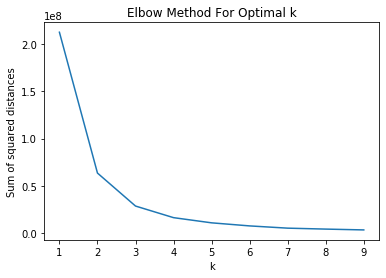

In [101]:
X = bike_stn[['Latitude','Longitude','Count']]

sum_sq_dist = []
k_range = range(1,10)
for k in k_range:
    kM = KMeans(n_clusters=k, random_state=0)
    y_pred = kM.fit_predict(X)
    sum_sq_dist.append(kM.inertia_)
plt.plot(k_range,sum_sq_dist)
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Choose k = 3

In [102]:
kM = KMeans(n_clusters=3, random_state=0)
y_pred = kM.fit_predict(X)

bike_stn['Cluster number'] = y_pred
bike_stn

,Street,Latitude,Longitude,Zip,Count,Cluster number
0,Fort York Blvd / Capreol Ct,43.640400,-79.399500,M5V,2354,1
1,Lower Jarvis St / The Esplanade,43.648220,-79.370922,M5E,1106,2
2,St. George St / Bloor St W,43.667510,-79.399821,M5R,2744,1
3,Madison Ave / Bloor St W,43.686100,-79.402500,M4V,1662,2
4,University Ave / Elm St,43.656322,-79.389114,M5G,1271,2
5,King St W / York St,43.647914,-79.383565,M5H,1918,1
6,Bay St / College St (East Side),43.660809,-79.385849,M5S,3447,1
8,Wellesley St / Queen's Park Cres,43.663611,-79.390628,M5S,1363,2
9,King St E / Jarvis St,43.650458,-79.371903,M5C,1765,2
10,King St W / Spadina Ave,43.645446,-79.395150,M5V,1045,2


In [110]:
# create map
map_clusters = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=13)

# set color scheme for the clusters
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, count, cluster in zip(bike_stn['Latitude'], bike_stn['Longitude'], bike_stn['Street'], bike_stn['Count'], bike_stn['Cluster number']):
    label = folium.Popup(str(poi) + ', Cluster ' + str(cluster)+ ', Count: '+ str(count), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We find that the point we selected (King/Bay intersection) lies in an area with high concewntration of Cluster 1/Cluster 2 points, which has a very high average ride counts (compared to cluster 0). This validates our choice of location to start a business.